In [12]:
# Importar las bibliotecas necesarias
import pandas as pd
from herramientas import obtener_resumen_valores_unicos
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Leer los datos
df = pd.read_csv('data/train.csv', delimiter = '|')
df1 = pd.read_csv('data/RentabilidadProduct.csv', delimiter = '|')

# Descripción de los datos

## Data Entrenamiento [train.csv]
* **fecha_compra** Dia donde un cliente hizo una compra.
* **customer_id** Codigo de cliente
* **product_id** Codigo de producto
* **type_id** Tipo de negocio (GA: Gastronomia, PA: Panificacion, BO: Bodegas)
* **business_id** Codigo tipo de producto (a que negocio pertenece el producto)
* **channel_id** Canal de venta (A: Diadia, B: Insuma, V: Tradicional)
* **cantidad_venta** Cantidad de producto comprado
* **monto_venta_transf** Monto de compra
* **peso_venta_transf** Volumen de compra

## Data Producto [RentabilidadProduct.csv]
* **product_id** Codigo de producto
* **family_id** Codigo de familia (Marca a la que pertenece)
* **negocio_id** Codigo tipo de producto (a que negocio pertenece el producto)
* **category_id** Codigo de categoria de producto
* **tier_id** Codigo de tier, indica jerarquia de un producto ( 1 = premiun, 2 = mainstream, 3=economy, 4=super economy)
* **utilidad_bruta_transf** Utilidad bruta del producto

In [14]:
obtener_resumen_valores_unicos(df)

,Columna,Tipo de Dato,Valores Únicos,Total Valores,Valores Nulos
0,fecha_compra,object,327,2167848,0
1,customer_id,int64,15312,2167848,0
2,product_id,int64,1043,2167848,0
3,type_id,object,3,2167848,0
4,business_id,int64,10,2167848,0
5,channel_id,object,3,2167848,0
6,cantidad_venta,float64,147,2167848,0
7,monto_venta_transf,float64,36737,2167848,0
8,peso_venta_transf,float64,2382,2167848,0


In [15]:
obtener_resumen_valores_unicos(df1)

,Columna,Tipo de Dato,Valores Únicos,Total Valores,Valores Nulos
0,product_id,int64,937,937,0
1,family_id,int64,231,937,0
2,negocio_id,int64,3,937,0
3,category_id,int64,50,937,0
4,tier_id,int64,4,937,0
5,utilidad_bruta_transf,float64,925,937,0


# Filtrado colaborativo basado en usuarios (User-User)

# Matriz de calificaciones

In [16]:
# Agregamos un ranking
# Agrupar por cliente y producto, y contar la frecuencia de compra
frecuencia_compra = df.groupby(['customer_id', 'product_id']).size().reset_index(name='frecuencia')

# Normalizar el ranking entre 1 y 5
frecuencia_compra['ranking'] = frecuencia_compra['frecuencia'].apply(lambda x: 5 if x > 10 else (1 if x == 1 else (x-1)//2))

# Fusionar el ranking con el DataFrame original
df_ranking = pd.merge(df, frecuencia_compra[['customer_id', 'product_id', 'ranking']], on=['customer_id', 'product_id'], how='left')

In [17]:
df_ranking.head(3)

,fecha_compra,customer_id,product_id,type_id,business_id,channel_id,cantidad_venta,monto_venta_transf,peso_venta_transf,ranking
0,2022-01-31,7157,510,BO,21,V,1.0,0.153431,0.005211,2
1,2022-01-31,7157,512,BO,21,V,1.0,0.153431,0.005211,1
2,2022-01-31,9382,510,BO,21,V,1.0,0.153431,0.005211,0


In [18]:
# Crear la matriz de calificaciones usando pivot
df_matriz = df_ranking.drop_duplicates(subset=['customer_id', 'product_id'])
matriz_calificaciones = df_matriz.pivot(index='customer_id', columns='product_id', values='ranking')

# Rellenar los valores NaN con cero si es necesario
matriz_calificaciones = matriz_calificaciones.fillna(0)

# Ahora, matriz_calificaciones es un DataFrame que contiene la matriz de calificaciones que buscas


# Cálculo de Similitud entre Usuarios

## Similitud del Coseno

In [21]:
# Calcular la similitud del coseno entre los usuarios
cosine_similarity_matrix = cosine_similarity(matriz_calificaciones)

print("Matriz de similitud del coseno:")
print(cosine_similarity_matrix)


Matriz de similitud del coseno:
[[1.         0.39337812 0.52494427 ... 0.         0.         0.        ]
 [0.39337812 1.         0.36095673 ... 0.         0.         0.        ]
 [0.52494427 0.36095673 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.28284271 0.64549722]
 [0.         0.         0.         ... 0.28284271 1.         0.18257419]
 [0.         0.         0.         ... 0.64549722 0.18257419 1.        ]]


In [35]:
def predict_ratings(similarity_matrix, matriz_calificaciones):
    # Calcular el peso promedio para cada ítem
    weighted_ratings = np.dot(similarity_matrix, matriz_calificaciones)
    
    # Suma de las similitudes para cada usuario
    sum_of_similarities = np.abs(similarity_matrix).sum(axis=1).reshape(-1, 1)
    
    # Evitar dividir por cero (en caso de que un usuario no tenga similitudes con otros)
    sum_of_similarities[sum_of_similarities == 0] = 1
    
    predicted_ratings = weighted_ratings / sum_of_similarities
    
    return predicted_ratings

# Predicciones usando las matrices de similitud
# pearson_predictions = predict_ratings(pearson_similarity_matrix, matriz_calificaciones)
cosine_predictions = predict_ratings(cosine_similarity_matrix, matriz_calificaciones)

print("\nPredicciones con la similitud del coseno:")
print(cosine_predictions)



Predicciones con la similitud del coseno:
[[4.24301502e-02 1.92485724e-02 8.92551561e-02 ... 3.64403852e-02
  2.46329238e-02 2.17850133e-02]
 [3.43527089e-02 1.56888317e-02 8.14040976e-02 ... 2.91108399e-02
  1.99072027e-02 1.81820551e-02]
 [4.33572753e-02 2.00004228e-02 8.98556632e-02 ... 3.47040153e-02
  2.24743625e-02 2.05042736e-02]
 ...
 [4.40331248e-04 8.27398333e-04 2.52171488e-02 ... 8.58074005e-04
  2.01723949e-04 5.33130690e-04]
 [9.09630090e-05 2.56625952e-04 1.94242525e-02 ... 7.15777458e-04
  1.45213171e-04 5.86549278e-04]
 [1.72008630e-04 1.17384054e-04 2.33276475e-02 ... 9.61607848e-04
  1.59110335e-04 4.40952175e-04]]


In [41]:
# Función para obtener los top 30 productos
def top_30_products(cosine_predictions):
    sorted_indices = np.argsort(cosine_predictions, axis=1)[:, ::-1]
    top_30_indices_for_each_user = sorted_indices[:, :30]
    return top_30_indices_for_each_user

top_products_indices = top_30_products(cosine_predictions)

# Crear un DataFrame
# Suponiendo que los customer_id van desde 1 hasta el número de usuarios
# y los product_id van desde 1 hasta el número de productos
customer_ids = np.arange(1, cosine_predictions.shape[0] + 1)
product_ids_lists = [list(row + 1) for row in top_products_indices]  # Sumamos 1 para que los product_ids empiecen en 1

df = pd.DataFrame({
    'customer_id': customer_ids,
    'top_30_product_ids': product_ids_lists
})

print(df)


       customer_id                                 top_30_product_ids
0                1  [455, 451, 413, 403, 120, 425, 405, 202, 982, ...
1                2  [455, 451, 413, 403, 120, 425, 405, 119, 982, ...
2                3  [120, 455, 202, 413, 451, 403, 982, 425, 885, ...
3                4  [120, 982, 885, 451, 455, 413, 202, 403, 886, ...
4                5  [451, 455, 413, 403, 120, 425, 982, 405, 202, ...
...            ...                                                ...
15307        15308  [768, 735, 66, 968, 327, 37, 807, 162, 173, 96...
15308        15309  [66, 768, 735, 327, 119, 968, 37, 808, 967, 80...
15309        15310  [768, 735, 37, 66, 162, 173, 968, 967, 327, 49...
15310        15311  [735, 768, 66, 968, 37, 807, 327, 967, 162, 80...
15311        15312  [768, 735, 66, 37, 173, 162, 808, 327, 967, 49...

[15312 rows x 2 columns]


In [42]:
# Convertir las listas a cadenas de caracteres separadas por espacios
df['top_30_product_ids'] = df['top_30_product_ids'].apply(lambda x: ' '.join(map(str, x)))

df.to_csv('User-User.csv', index=False)

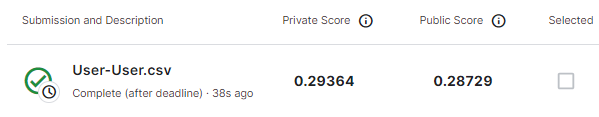